# Import packages

### Import python packages

In [1]:
import re,os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from scipy.stats import linregress
from sklearn.decomposition import PCA
from tqdm import trange, tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import scipy
from scipy import interpolate
tfk = tf.keras
tfkl = tf.keras.layers
clear_output()

### Import custom packages

In [2]:
from MRA_generate import MRA_generate
from symae_model import SymAE
from parameters import *
from redatuming import redatuming
from latent import latent
from plot_training import plot_training
from plot_redatuming import plot_redatuming
from plot_save import plot_save

Num GPUs Available:  1
TensorFlow Version:  2.9.1


# Train SymAE

### Initialize SymAE and load weights

In [3]:
model = SymAE(N,nt,d,p,q,kernel_size,filters,dropout_rate)
#model.load_weights('./checkpoint/'+'p=%d,q=%d,ne=%d'%(p,q,ne))
clear_output()

In [4]:
model.latentcat.drop.rate = 0.0
model.latentcat.drop.stddev = 0.0

### Data

In [29]:
n_datum = 10000
n_basis = 2
basis = tf.constant([np.cos(k*2*np.pi/d*np.arange(0,d,1)) for k in range(n_basis-1)], dtype=tf.float32)
basis = np.concatenate([basis, np.array([[1]*50+[-1]*50])], axis=0)

all_instance = np.empty((n_datum, nt, d))
all_state = np.empty((n_datum, d))
all_shift = np.empty((n_datum, nt), dtype=int)
for i in range(n_datum):
    coef = tf.random.uniform((1,n_basis), -1, 1)
    all_state[i,:] = coef@basis
    all_shift[i,:] = np.random.randint(0, d, (nt))
    for j in range(nt):
        shift = all_shift[i,j]
        all_instance[i,j,:] = np.roll(all_state[i,:], shift)

In [30]:
train_dataset_single = tf.data.Dataset.from_tensor_slices((all_instance,all_state,all_shift)).batch(8)   

In [31]:
n_pair = 10000
all_state_source = np.empty((n_pair, nt, d))
all_shift_source =  np.empty((n_pair, nt, d), dtype=int)
all_redatum = np.empty((n_pair, nt, d))
for k in range(n_pair):
    i = np.random.randint(0, n_datum)
    j = np.random.randint(0, n_datum)
    if k<n_pair*0.8:
        j = i
    all_state_source[k,:,:] = all_instance[i,:,:]
    all_shift_source[k,:,:] = all_instance[j,:,:]
    for t in range(nt):
        all_redatum[k,t,:] = np.roll(all_state[i,:], all_shift[j,t])

In [32]:
train_dataset_pair = tf.data.Dataset.from_tensor_slices((all_state_source,
                                                         all_shift_source,
                                                         all_redatum)).shuffle(512).batch(128)   

### PCA

Text(0.5, 0.98, 'Show the shape of all $n_{test}$ = 5 states')

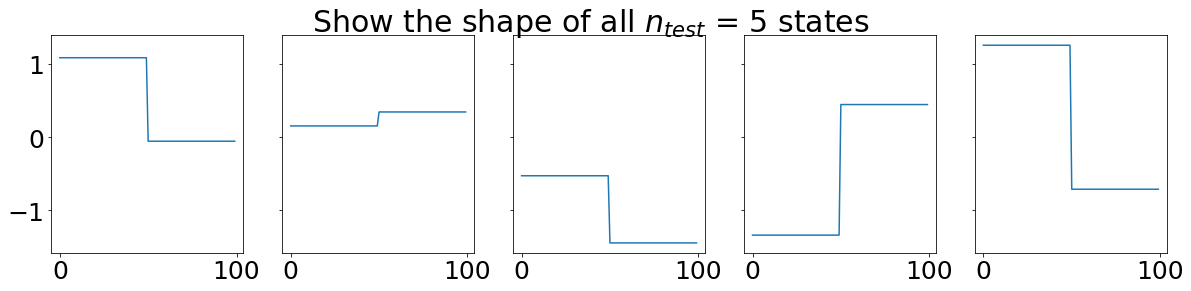

In [33]:
ne_test = 5
repeat = d//nt
nx = ne_test * repeat
X_test = np.empty((nx,nt,d))
states_sub = np.empty((ne_test, d))
cos = tf.constant([np.cos(k*2*np.pi/d*np.arange(0,d,1)) for k in range(n_basis)], dtype=tf.float32)
coef = tf.random.uniform((ne_test,n_basis), -1, 1)
states_sub = tf.linalg.matmul(coef,basis)
thetas_test = np.repeat(states_sub, repeat, axis=0)
ls_test = np.tile(np.reshape(np.arange(d), (repeat, nt)), (ne_test, 1))
for i in range(nx):
    for j in range(nt):
        X_test[i,j,:] = np.roll(thetas_test[i,:], ls_test[i,j])
df_states = pd.DataFrame(np.repeat(range(ne_test), d),columns=['state'])
df_shifts = pd.DataFrame(ls_test.reshape(-1, 1), columns=['shift'])
clear_output()
fig, axs = plt.subplots(1, ne_test, sharex=True, sharey=True, figsize=(ne_test*4, 4))
for i in range(ne_test):
    axs[i].plot(range(d), X_test[i*repeat,0,:])
plt.suptitle('Show the shape of all $n_{test}$ = %d states'%ne_test)

### Optimizer

In [38]:
optimizer = tf.keras.optimizers.Adam(0.0001)

### Loss

In [39]:
mse = tf.keras.losses.MeanSquaredError()
def synthesize(theta, shifts):
    output_list = []    
    for i in range(nt):
        shift = shifts[i]
        output_list.append(tf.roll(theta, shift, axis=0))
    synthetic = tf.stack(output_list)  
    #synthetic = tf.expand_dims(synthetic, 0)
    #synthetic = tf.expand_dims(synthetic, -1)
    return synthetic

def redatuming_loss(model, tem):
    state_instance, shift_instance, redatum_instance = tem
    latent_code_state = model.encoder(state_instance)
    latent_code_shift = model.encoder(shift_instance)
    latent_state = latent_code_state[:, 0:p]
    latent_shift = latent_code_shift[:, p:p+q*nt]
    merger = tf.concat([latent_state, latent_shift], axis=1)
    redatum = model.decoder(merger)
    synthetic = redatum_instance
    return  mse(redatum, synthetic)

@tf.function
def train_step(model, tem):
    with tf.GradientTape() as tape:
        loss = redatuming_loss(model, tem)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [40]:
for epoch in range(10000):
    for batch,tem in enumerate(train_dataset_pair):
        loss = train_step(model, tem)
        #clear_output(wait=True)
        #print("For epoch {:d}, batch {:d}, loss is {:f}.".format(epoch, batch, loss))
    print("For epoch {:d}, loss is {:f}.".format(epoch, loss))
    if epoch % 10 == 0:
        clear_output(wait = True)
        Ns = model.encoder.predict(X_test)[:, p:p+q*nt]
        N_reshaped = Ns.reshape(-1, q)
        pca_N = N_reshaped
        df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'])
        df = pd.concat([df,df_states,df_shifts],axis=1)
        fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='state', 
                         text='shift', title='q=%d,loss=%f'%(q,loss), 
                         color_continuous_scale=px.colors.sequential.Viridis)
        fig.update_layout(height=500)
        fig.show()

1/1 [==============================] - 0s 39ms/step


For epoch 931, loss is 0.116269.


KeyboardInterrupt: 

### Save weights

In [14]:
#model.save_weights('./checkpoint/'+datetime.now().strftime("%B%d"))
model.save_weights('./checkpoint/'+'p=%d,q=%d,predata'%(p,q))
print("weights saved")

weights saved


### Save plot

In [ ]:
#plot_save(fig,ID=-1)

# PCA

In [ ]:
ne_test = 10
repeat = d//nt
nx = ne_test * repeat
X_test = np.empty((nx,nt,d))
states_sub = np.empty((ne_test, d))
for i in range(ne_test):
    thetas = tf.random.uniform((1, d), -1, 1)
    thetas = tf.nn.conv1d(tf.expand_dims(thetas, -1), tf.ones((20, 1, 1)), 
                          stride=1, padding='SAME')[:,:,0]
    states_sub[i, :] = thetas
thetas_test = np.repeat(states_sub, repeat, axis=0)
ls_test = np.tile(np.reshape(np.arange(d), (repeat, nt)), (ne_test, 1))
for i in range(nx):
    for j in range(nt):
        X_test[i,j,:] = np.roll(thetas_test[i,:], ls_test[i,j])
pca_cb = PCA(n_components=2)
df_states = pd.DataFrame(np.repeat(range(ne_test), d),columns=['state'])
df_shifts = pd.DataFrame(ls_test.reshape(-1, 1), columns=['shift'])
clear_output()

In [ ]:
Ns = model.encoder.predict(X_test)[:, p:p+q*nt]
N_reshaped = Ns.reshape(-1, q)
if q==2:
    pca_N = N_reshaped
else:
    pca_N = pca_cb.fit_transform(N_reshaped)
df = pd.DataFrame(pca_N, columns = ['1st','2nd'])
df = pd.concat([df,df_states,df_shifts],axis=1)
fig = px.scatter(df, x='1st', y='2nd', color='state', 
                 text='shift', title='q=%d,loss=%f'%(q,loss), 
                 color_continuous_scale=px.colors.sequential.Viridis)
fig.update_layout(height=500)

# Redatuming

In [16]:
coef = tf.random.uniform((N,3), -1, 1)
thetas = tf.linalg.matmul(coef,cos)
def g(n,x):
    return thetas[n,int(x*d)]
def find(state,nuisance):
    MRA_data = MRA_generate(d,nt,1,sigma,ne,g,replace=1)
    for i in range(1000):
        MRA_data.generate_default()
        if MRA_data.states[0] != state:
            continue
        for j in range(nt):
            if MRA_data.shifts[0][j] == nuisance:
                return MRA_data, j

### Choose which 2 states and shifts you want to redatum 

In [17]:
MRA1, t1 = find(0,0)
MRA2, t2 = find(1,36)

### Redatuming and the visualize it

The MSE of C1N2 is: 0.696986
The MSE of C2N1 is: 0.208430


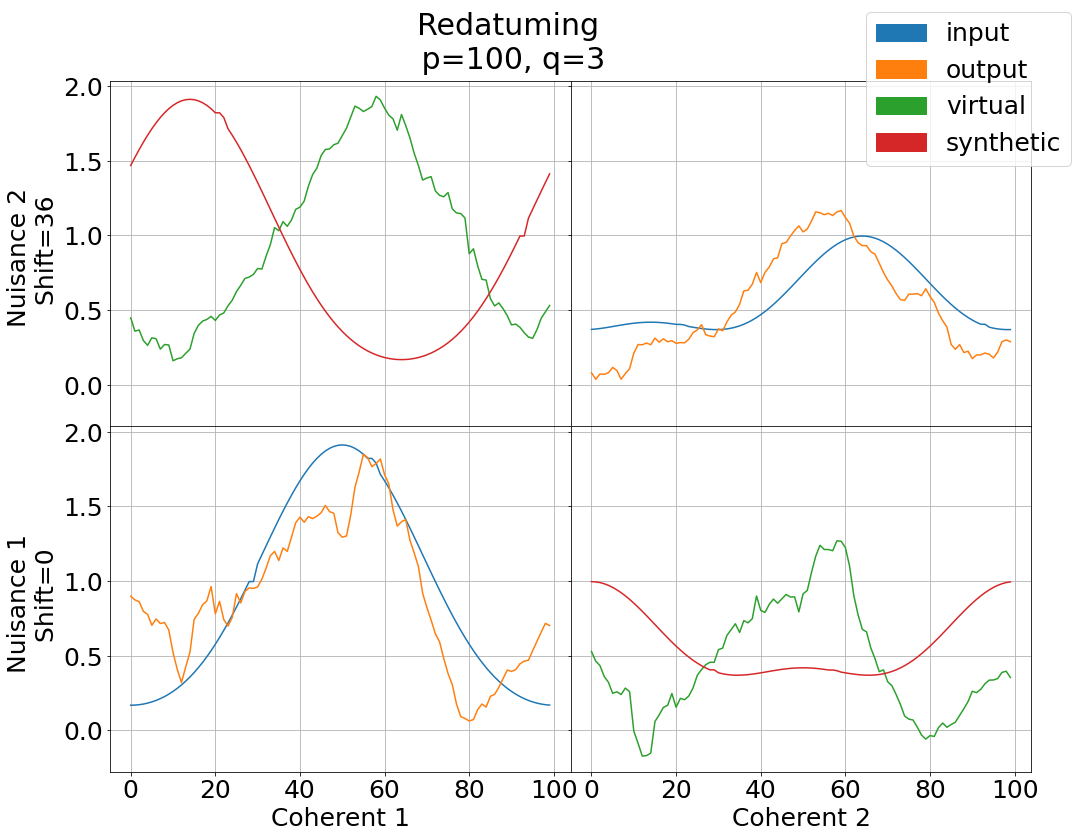

In [18]:
redatum = redatuming(model,MRA1,MRA2,t1,t2)
MSE_C1_N2, MSE_C2_N1 = redatum.MSE()
fig = plot_redatuming(redatum)
clear_output()
print('The MSE of C1N2 is: %f'%MSE_C1_N2)
print('The MSE of C2N1 is: %f'%MSE_C2_N1)

### Save redatuming plot

In [ ]:
plot_save(fig,ID=-1)

### List many redatuming

In [ ]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,:]
def enc(state, shift):
    tem = np.array( [g(state, ((k+shift)%d)/d) for k in range(d)] )
    tem = tem[np.newaxis, np.newaxis, :, np.newaxis]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.encoder.predict(tem, verbose=0)
    return tem[0][0:p+q]

In [ ]:
state_source = 0
nuisance_source = 40
fig, axs = plt.subplots(1, d, sharex=True, sharey=True, figsize=(4*d,4), dpi=40)
for i in trange(d):
    coherent_code = enc(state_source, 0)[0: p]
    nuisance_code = enc(nuisance_source, i)[p: p+q]
    latent_code = np.concatenate([coherent_code, nuisance_code], axis=0)
    axs[i].plot(range(d), dec(latent_code))
    axs[i].set_title('%d'%i)
plt.suptitle('$\hat{X}_{s=%d \mapsto s=%d}$'%(nuisance_source, state_source), fontsize=50)
plt.subplots_adjust(top=0.6)
plt.show()
#fig.savefig('./plots/%dto%d'%(nuisance_source, state_source))

# Interpolation

In [ ]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,:]
def enc(state, shift):
    tem = np.array( [g(state, ((k+shift)%d)/d) for k in range(d)] )
    tem = tem[np.newaxis, np.newaxis, :, np.newaxis]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.encoder.predict(tem, verbose=0)
    return tem[0][0:p+q]

### Set endpoints

In [ ]:
state = -1
shift1 = 0
shift2 = 30

In [ ]:
def g(n,x):
    if n==-1:
        return int(x<0.5)
    return np.exp(-math.sqrt(n+1)*(x-0.5)**2)

### Linear

In [ ]:
interpolation_number = L = 10
interpolation = np.empty((L,d))
for i, alpha in enumerate(range(L)):
    alpha = alpha / L
    code1 = enc(state, shift1)
    code2 = enc(state, shift2)
    code = alpha*code1 + (1-alpha)*code2
    interpolation[i:i+1,:] = dec(code).T
fig = plt.figure(figsize=(10,6))
for i, alpha in enumerate(range(L)):
    alpha = alpha / L
    plt.plot(range(d),interpolation[i,:], color=(alpha,0,1-alpha))
plt.grid()

### Cubic Spline

In [ ]:
class spline():
    def __init__(self, state):
        self.state = state
        self.x = np.arange(0, d, 1)
        self.y = np.empty((q, len(self.x)))
        self.tck = []
        self.center = enc(state, 0)[0:p]
        for j in trange(len(self.x)):
            l = self.x[j]
            latent_code = enc(state, l)
            for i in range(q):
                self.y[i,j] = latent_code[p+i]
        for i in range(q):
            self.tck.append(interpolate.splrep(self.x, self.y[i,:], per=True))
    def call(self, shift):
        return np.array([interpolate.splev(shift, self.tck[i], der=0) for i in range(q)])
    def call_batch(self, shifts):
        return np.array([[interpolate.splev(shift, self.tck[i], der=0) for i in range(q)] for shift in shifts])
    def decode(self, shift):
        return dec(np.hstack([self.center, self.call(shift)]))
    def decode_batch(self, shifts):
        return np.array([self.decode(shift) for shift in tqdm(shifts)])

In [ ]:
spline_obj = spline(state)

In [ ]:
spline_obj.decode_batch([5,6]).shape

In [ ]:
plt.plot(range(d), spline_obj.decode(5))

### By hand

In [ ]:
code1 = enc(state, shift1)
code2 = enc(state, shift2)
code = 0.5*code1 + 0.5*code2 + 1.0
interpolation = dec(code)
fig = plt.figure(figsize=(10,6))
plt.plot(range(d), [g(state, ((k+shift1)%d)/d) for k in range(d)], color=(1,0,0))
plt.plot(range(d), [g(state, ((k+shift2)%d)/d) for k in range(d)], color=(0,0,1))
plt.plot(range(d),interpolation, color=(1,0,1))
plt.grid()

### PCA

In [ ]:
pca = PCA(2)
Ns = np.empty((100,q))
for i in trange(100):
    shift = i
    Ns[i,:] = enc(state, shift)[p:p+q]

In [ ]:
pca_N = pca.fit_transform(Ns)
pca_N1 = pca.transform(code1[np.newaxis, p:p+q])
pca_N2 = pca.transform(code2[np.newaxis, p:p+q])
pca_N_hand = pca.transform(code[np.newaxis, p:p+q])
pca_N_spline = pca.transform(spline_obj.call_batch(np.arange(0,100,0.1)))

In [ ]:
data0 = go.Scatter(x=pca_N[:,0], y=pca_N[:,1], mode='markers', name='dataset')
data1 = go.Scatter(x=pca_N1[:,0], y=pca_N1[:,1], mode='markers', marker=dict(color='rgb(255, 0, 0)'), name='endpoint1')
data2 = go.Scatter(x=pca_N2[:,0], y=pca_N2[:,1], mode='markers', marker=dict(color='rgb(255, 0, 0)'), name='endpoint2')
data_line = go.Scatter(x=[pca_N1[0,0],pca_N2[0,0]], y=[pca_N1[0,1],pca_N2[0,1]], marker=dict(color='rgb(255, 200, 0)'), name='line')
data_hand = go.Scatter(x=pca_N_hand[:,0], y=pca_N_hand[:,1], mode='markers', marker=dict(color='rgb(150, 255, 150)'), name='hand')
data_spline = go.Scatter(x=pca_N_spline[:,0], y=pca_N_spline[:,1], marker=dict(color='rgb(200, 50, 200)'), name='spline')
fig = go.Figure(data=[data0,data_line,data1,data2,data_hand,data_spline])
fig.update_layout(height=600)
fig.show()

In [ ]:
pca = PCA(n_components=3)
MRA_pca = MRA_generate(d,nt,1000,sigma,ne,g,replace=1)
MRA_pca.generate_default()
Cs,Ns = latent(model,MRA_pca)

In [ ]:
pca.fit(Cs)
pca_C = pca.fit_transform(Cs)
df = pd.DataFrame(pca_C, columns = ['1st','2nd','3rd'])
tem = pd.DataFrame(MRA_pca.states,columns=['state']).astype('object')
df = pd.concat([df,tem],axis=1)
fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='state')
fig.show()

In [ ]:
state = 0
N_reshaped = Ns[MRA_pca.states==state,:].reshape(-1,q) 
N_shifts = MRA_pca.shifts[MRA_pca.states==state,:].reshape(-1,1)
pca = PCA(n_components=3)
pca.fit(N_reshaped)
pca_N = pca.fit_transform(N_reshaped)
df = pd.DataFrame(pca_N, columns = ['1st','2nd','3rd'])
tem = pd.DataFrame(N_shifts,columns=['shift'])
df = pd.concat([df,tem],axis=1)
fig = px.scatter_3d(df, x='1st', y='2nd', z='3rd', color='shift')
fig.show()

p-space is another name of the latent coherent space

In [ ]:
pca_C = pca.fit_transform(Cs)
center = np.empty((ne,2))
fig = plt.figure(figsize=(5,4),dpi=100)
for i in range(ne):
    center[i,:] = sum(pca_C[MRA_pca.states==i,:])/sum(MRA_pca.states==i)
    plt.text(center[i,0],center[i,1],"state=%d"%i,fontsize=15)
for i in trange(1000):
    plt.scatter(pca_C[i,0],pca_C[i,1],color='C%d'%(MRA_pca.states[i]))
plt.title('PCA of p-space',fontsize=15)
plt.tick_params(labelsize=15)
plt.tight_layout()